In [1]:
import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Connect to the database
connection = pymysql.connect(
    host="35.198.14.190",
    user="rehpires",
    password="068510",
    database="cloudwalk_case")

# Load the table as a DataFrame
df = pd.read_sql("SELECT * FROM transactional_sample", connection)
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["transaction_hour"] = df["transaction_date"].dt.hour
connection.close()

C:\Users\repires\AppData\Local\Temp\1\ipykernel_7144\2881354287.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM transactional_sample', connection)


In [3]:
df.head(10)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_hour
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:33,374.56,285475,0,23
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:38,734.87,497105,1,22
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43,760.36,,0,22
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:20,2556.13,,1,21
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53,55.36,860232,0,21
5,21320403,59566,40759,516292******8220,2019-12-01 21:25:53,60.49,192705,0,21
6,21320404,20917,25661,650485******9310,2019-12-01 21:25:20,318.37,760932,0,21
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:06,188.68,486,1,21
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:22,352.77,486,1,21
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55,345.68,486,1,21


In [4]:
%matplotlib inline
sns.set(style="darkgrid")

<AxesSubplot: xlabel='transaction_hour', ylabel='Count'>

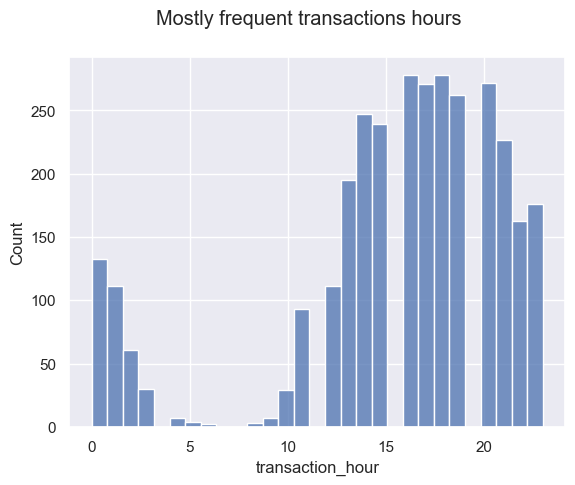

In [5]:
# Plot histogram of transaction hours
fig, ax = plt.subplots(1)
fig.suptitle("Mostly frequent transactions hours")

sns.histplot(data=df, x="transaction_hour")

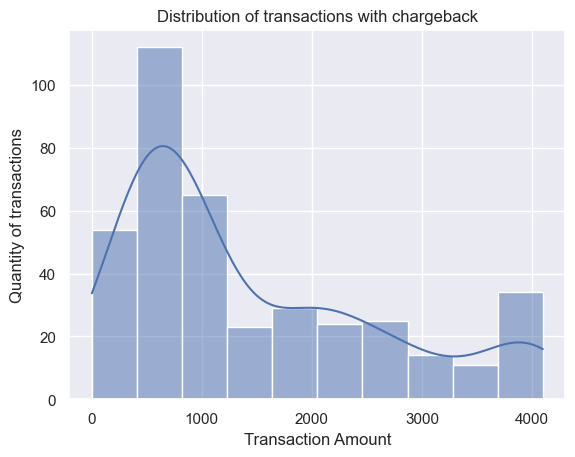

In [6]:
ax = sns.histplot(df.loc[df["has_cbk"] == 1].transaction_amount,kde=True).set_title("Distribution of transactions with chargeback")

plt.xlabel("Transaction Amount")
plt.ylabel("Quantity of transactions")
plt.show()

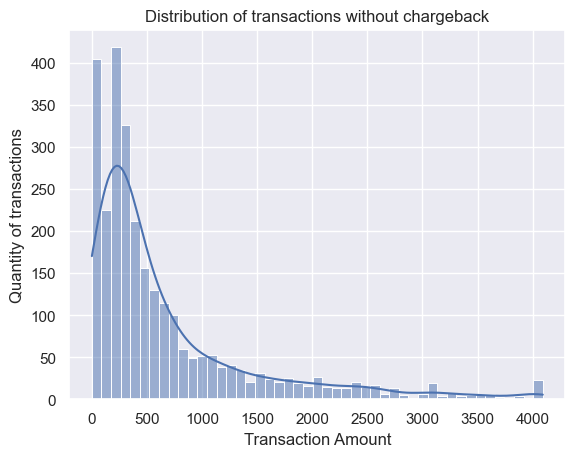

In [7]:
ax = sns.histplot(df.loc[df["has_cbk"] == 0].transaction_amount,kde=True).set_title("Distribution of transactions without chargeback")

plt.xlabel("Transaction Amount")
plt.ylabel("Quantity of transactions")
plt.show()

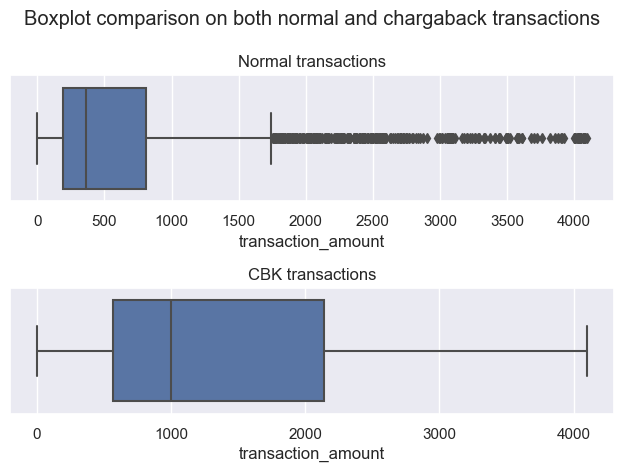

In [8]:
df_norm = df[df["has_cbk"] == 0]
df_cbk = df[df["has_cbk"] == 1]

fig, ax = plt.subplots(2)

fig.suptitle("Boxplot comparison on both normal and chargaback transactions")

sns.boxplot(data = df_norm, x="transaction_amount", ax=ax[0]).set_title("Normal transactions")
sns.boxplot(data = df_cbk, x="transaction_amount", ax=ax[1]).set_title("CBK transactions")

plt.tight_layout()

In [9]:
#Detecting cards with unusual number of transactions
# Group the transactions by card number and count the number of transactions for each card
card_counts_cbk = df[df["has_cbk"] == 1].groupby("card_number").size().reset_index(name="transactions_cbk")

# Sort the card counts in descending order to see the cards with the most transactions
card_counts_cbk = card_counts_cbk.sort_values(by="transactions_cbk", ascending=False)

# Analyze cars with more than 2 transactions with at least 1 chargeback
suspects_cards = card_counts_cbk[card_counts_cbk["transactions_cbk"] > 2]

# Filter the original dataframe to show only frequent cards
suspects_cards = df[df["card_number"].isin(suspects_cards["card_number"])]
suspects_cards.sort_values(by="card_number", ascending=False)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_hour
1314,21321712,89943,86411,651653******2256,2019-11-24 21:09:36,1872.98,597308,1,21
1072,21321470,89943,86411,651653******2256,2019-11-27 19:51:01,2030.64,597308,1,19
1803,21322201,89943,86411,651653******2256,2019-11-22 19:11:14,1979.46,597308,1,19
1431,21321829,89943,86411,651653******2256,2019-11-23 19:54:02,1952.18,597308,1,19
2082,21322480,89943,86411,651653******2256,2019-11-21 21:37:36,140.38,597308,1,21
...,...,...,...,...,...,...,...,...,...
596,21320994,1308,96025,406655******7343,2019-11-29 16:46:59,2288.47,438940,1,16
692,21321090,1308,79054,406655******7343,2019-11-29 12:51:18,2231.98,101848,1,12
709,21321107,1308,96025,406655******5764,2019-11-29 11:32:14,2412.28,438940,1,11
723,21321121,1308,96025,406655******5764,2019-11-29 03:30:44,2486.70,438940,1,3


In [10]:
#Detecting users with unusual number of transactions
# Group the data by user_id and count the number of transactions per user
user_id_counts = df.groupby("user_id").size().reset_index(name="transactions")
user_id_counts = user_id_counts.sort_values(by="transactions", ascending=False)

#Detecting users with unusual number of transactions that already had fraud chargeback label
# Group the data by user_id and count the number of transactions per user
user_frauds = df[df["has_cbk"] == 1].groupby("user_id").size().reset_index(name="transactions with fraud")

In [11]:
result = pd.merge(user_id_counts, user_frauds, on="user_id",sort=True)
result

,user_id,transactions,transactions with fraud
0,900,1,1
1,2708,2,1
2,3157,1,1
3,3584,6,4
4,4651,3,3
...,...,...,...
148,96976,1,1
149,97150,1,1
150,97611,2,2
151,99396,5,5


In [12]:
#Detecting users with unusual number of transactions
# Group the data by card_id and count the number of transactions per card_id
card_id_counts = df.groupby("card_number").size().reset_index(name="transactions")
card_id_counts = card_id_counts.sort_values(by="transactions", ascending=False)

#Detecting users with unusual number of transactions that already had fraud chargeback label
# Group the data by card number and count the number of transactions per card
card_frauds = df[df["has_cbk"] == 1].groupby("card_number").size().reset_index(name="transactions with fraud")
result = pd.merge(card_id_counts, card_frauds, on="card_number",sort=True)
result

,card_number,transactions,transactions with fraud
0,230650******5729,1,1
1,230744******4802,2,2
2,230744******950,1,1
3,403002******5770,1,1
4,406168******2582,1,1
...,...,...,...
269,650486******4290,1,1
270,650516******7004,1,1
271,650516******9201,3,3
272,650727******5418,3,3


In [13]:
# group by merchant_id and count the number of transactions
merchant_id_grouped = df.groupby("merchant_id").size().reset_index(name="transactions_count")

# group by merchant_id and count the number of chargebacks (has_cbk=1)
chargebacks_grouped = df[df["has_cbk"] == 1].groupby("merchant_id").size().reset_index(name="chargebacks_count")

# merge the two grouped dataframes on merchant_id
merchant_analysis = merchant_id_grouped.merge(chargebacks_grouped, on="merchant_id", how="left")

# fill missing values of chargebacks_count with 0
merchant_analysis = merchant_analysis.fillna(0)

# calculate the chargeback rate as chargebacks_count / transactions_count
merchant_analysis["chargeback_rate"] = merchant_analysis["chargebacks_count"] / merchant_analysis["transactions_count"]

In [14]:
merchant_analysis[(merchant_analysis["transactions_count"]>1) & (merchant_analysis["chargebacks_count"]>0)]

,merchant_id,transactions_count,chargebacks_count,chargeback_rate
20,1308,15,15.0,1.000000
52,3531,2,2.0,1.000000
70,4153,6,5.0,0.833333
77,4705,22,19.0,0.863636
97,5404,4,1.0,0.250000
...,...,...,...,...
1637,92895,2,1.0,0.500000
1655,94198,2,1.0,0.500000
1713,97291,7,4.0,0.571429
1729,98272,5,3.0,0.600000
